In [4]:
#Uploading Sentinel-2 jp2 bands and Hong Kong boundary shapefile
#8 JP2 files (B02, B03, B04, B08 from two tiles) and shapefile
from google.colab import files
uploaded = files.upload()

Saving T49QHE_20231125T030029_B08_10m.jp2 to T49QHE_20231125T030029_B08_10m.jp2
Saving T49QHE_20231125T030029_B03_10m.jp2 to T49QHE_20231125T030029_B03_10m.jp2
Saving T49QHE_20231125T030029_B04_10m.jp2 to T49QHE_20231125T030029_B04_10m.jp2
Saving T49QHE_20231125T030029_B02_10m.jp2 to T49QHE_20231125T030029_B02_10m.jp2
Saving T49QGE_20231125T030029_B08_10m.jp2 to T49QGE_20231125T030029_B08_10m.jp2
Saving T49QGE_20231125T030029_B04_10m.jp2 to T49QGE_20231125T030029_B04_10m.jp2
Saving T49QGE_20231125T030029_B03_10m.jp2 to T49QGE_20231125T030029_B03_10m.jp2
Saving T49QGE_20231125T030029_B02_10m.jp2 to T49QGE_20231125T030029_B02_10m.jp2
Saving gadm36_HKG_0.cpg to gadm36_HKG_0.cpg
Saving gadm36_HKG_0.dbf to gadm36_HKG_0.dbf
Saving gadm36_HKG_0.prj to gadm36_HKG_0.prj
Saving gadm36_HKG_0.shp to gadm36_HKG_0.shp
Saving gadm36_HKG_0.shx to gadm36_HKG_0.shx


In [62]:
!pip install geopandas rasterio scikit-learn matplotlib

In [5]:
#Importing libraries
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.mask import mask
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os
import tempfile

In [6]:
#Changing file names
tile1_bands = {
    'B02': 'T49QHE_20231125T030029_B02_10m.jp2',
    'B03': 'T49QHE_20231125T030029_B03_10m.jp2',
    'B04': 'T49QHE_20231125T030029_B04_10m.jp2',
    'B08': 'T49QHE_20231125T030029_B08_10m.jp2'
}

tile2_bands = {
    'B02': 'T49QGE_20231125T030029_B02_10m.jp2',
    'B03': 'T49QGE_20231125T030029_B03_10m.jp2',
    'B04': 'T49QGE_20231125T030029_B04_10m.jp2',
    'B08': 'T49QGE_20231125T030029_B08_10m.jp2'
}

In [7]:
# Opening with rasterio
b2_1 = rasterio.open(tile1_bands['B02'])
b3_1 = rasterio.open(tile1_bands['B03'])
b4_1 = rasterio.open(tile1_bands['B04'])
b8_1 = rasterio.open(tile1_bands['B08'])
b2_2 = rasterio.open(tile2_bands['B02'])
b3_2 = rasterio.open(tile2_bands['B03'])
b4_2 = rasterio.open(tile2_bands['B04'])
b8_2 = rasterio.open(tile2_bands['B08'])

In [63]:
#Merging the two tiles for each band
from rasterio.merge import merge

def merge_bands(band1, band2):
    mosaic, out_trans = merge([band1, band2])
    return mosaic, out_trans

b2_mosaic, b2_trans = merge_bands(b2_1, b2_2)
b3_mosaic, b3_trans = merge_bands(b3_1, b3_2)
b4_mosaic, b4_trans = merge_bands(b4_1, b4_2)
b8_mosaic, b8_trans = merge_bands(b8_1, b8_2)

In [10]:
#Loading Hong Kong shapefile
hong_kong = gpd.read_file('gadm36_HKG_0.shp')

In [11]:
#Reprojecting the Hong Kong shapefile to EPSG:32649 (UTM Zone 50N)
target_crs = "EPSG:32649"
hong_kong = hong_kong.to_crs(target_crs)

In [13]:
#Reprojecting the merged Sentinel-1 bands to EPSG:32649 (UTM Zone 50N)

from rasterio.transform import array_bounds

def reproject_raster(data, src_transform, src_crs, dst_crs):
    #Getting height and width of input raster
    height, width = data.shape[1], data.shape[2]

    #Computing bounds from array shape and transform
    left, bottom, right, top = array_bounds(height, width, src_transform)

    #Computing transform and output shape in new CRS
    dst_transform, dst_width, dst_height = calculate_default_transform(
        src_crs, dst_crs, width, height, left, bottom, right, top)

    #Preparing empty array for output
    dst_array = np.empty((data.shape[0], dst_height, dst_width), dtype=data.dtype)

    #Reprojecting each band individually
    for i in range(data.shape[0]):
        reproject(
            source=data[i],
            destination=dst_array[i],
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest
        )

    return dst_array, dst_transform, dst_crs

#Defining target CRS for Hong Kong
dst_crs = "EPSG:32649"

#Reprojecting each merged band raster to EPSG:32649
b2_mosaic_reproj, b2_trans_reproj, _ = reproject_raster(b2_mosaic, b2_trans, b2_1.crs, dst_crs)
b3_mosaic_reproj, b3_trans_reproj, _ = reproject_raster(b3_mosaic, b3_trans, b3_1.crs, dst_crs)
b4_mosaic_reproj, b4_trans_reproj, _ = reproject_raster(b4_mosaic, b4_trans, b4_1.crs, dst_crs)
b8_mosaic_reproj, b8_trans_reproj, _ = reproject_raster(b8_mosaic, b8_trans, b8_1.crs, dst_crs)

In [14]:
#Clip function to crop rasters by Hong Kong boundary
hong_kong_geom = [feature["geometry"] for feature in hong_kong.__geo_interface__["features"]]

def clip_raster(data, transform, shapes):
    """
    Clip a raster using a polygon geometry.
    """
    with rasterio.io.MemoryFile() as memfile:
        with memfile.open(
            driver='GTiff',
            height=data.shape[1],
            width=data.shape[2],
            count=data.shape[0],
            dtype=data.dtype,
            transform=transform,
            crs=dst_crs
        ) as dataset:
            for i in range(data.shape[0]):
                dataset.write(data[i], i + 1)
            clipped_image, clipped_transform = rasterio.mask.mask(dataset, shapes, crop=True)
    return clipped_image, clipped_transform

#Clipping reprojected bands
b2_clipped, b2_clipped_trans = clip_raster(b2_mosaic_reproj, b2_trans_reproj, hong_kong_geom)
b3_clipped, b3_clipped_trans = clip_raster(b3_mosaic_reproj, b3_trans_reproj, hong_kong_geom)
b4_clipped, b4_clipped_trans = clip_raster(b4_mosaic_reproj, b4_trans_reproj, hong_kong_geom)
b8_clipped, b8_clipped_trans = clip_raster(b8_mosaic_reproj, b8_trans_reproj, hong_kong_geom)

In [15]:
#Stacking clipped bands into one array for clustering (order: Blue, Green, Red, NIR)
stacked = np.stack([b2_clipped[0], b3_clipped[0], b4_clipped[0], b8_clipped[0]], axis=-1)

In [16]:
#Preparing data for clustering (reshape raster into 2D array)
n_rows, n_cols, n_bands = stacked.shape
stacked_2d = stacked.reshape((n_rows * n_cols, n_bands))

In [19]:
#Removing pixels with no data (assuming no-data=0)
mask = np.all(stacked_2d != 0, axis=1)
stacked_2d_masked = stacked_2d[mask]

In [20]:
#Running unsupervised k-means clustering (5 clusters)
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(stacked_2d_masked)
labels = np.full(stacked_2d.shape[0], -1)  #default label -1 for no data
labels[mask] = kmeans.labels_

In [21]:
#Reshaping labels back to raster shape
labels_raster = labels.reshape((n_rows, n_cols))

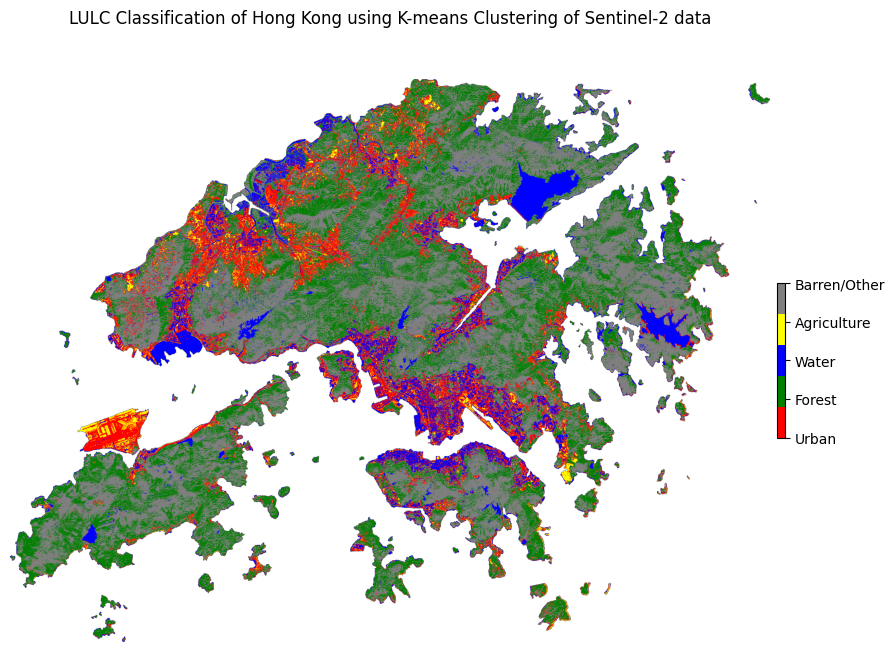

In [60]:
#Visualizing clustering result
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

#Defining colors for each cluster label
#Urban=red, Forest=green, Water=blue, Agriculture=yellow, Barren=gray
cluster_colors = ['#FF0000', '#008000', '#0000FF', '#FFFF00', '#808080']

#Creating a colormap from color list
cmap = ListedColormap(cluster_colors)

#Masking no-data values (-1)
masked_labels = np.ma.masked_equal(labels_raster, -1)

plt.figure(figsize=(10, 10))
im = plt.imshow(masked_labels, cmap=cmap, vmin=0, vmax=4)
plt.title("LULC Classification of Hong Kong using K-means Clustering of Sentinel-2 data", pad=40)

#Adding legend
cbar = plt.colorbar(im, ticks=range(5), fraction=0.01, pad=0.01)
cbar.ax.set_yticklabels(['Urban', 'Forest', 'Water', 'Agriculture', 'Barren/Other'], fontsize=10)

plt.axis('off')
plt.show()